In [2]:
from spectral import imshow, view_cube
import spectral.io.envi as envi
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

data_dir = "/Users/mmelnick/Work/Veracio/data/GeoVision Specim Data/15.01.19/SWIR/Row 1/SWIR_4_Cam_Test_Lumo2018_1_0m00_1m00_2019-01-15_18-46-47/capture/"
data_ref = envi.open(data_dir + "SWIR_4_Cam_Test_Lumo2018_1_0m00_1m00_2019-01-15_18-46-47.hdr", 
                       data_dir + "SWIR_4_Cam_Test_Lumo2018_1_0m00_1m00_2019-01-15_18-46-47.raw")
dark_ref = envi.open(data_dir + 'DARKREF_SWIR_4_Cam_Test_Lumo2018_1_0m00_1m00_2019-01-15_18-46-47.hdr',
                     data_dir + 'DARKREF_SWIR_4_Cam_Test_Lumo2018_1_0m00_1m00_2019-01-15_18-46-47.raw')
white_ref = envi.open(data_dir + 'WHITEREF_SWIR_4_Cam_Test_Lumo2018_1_0m00_1m00_2019-01-15_18-46-47.hdr', 
                      data_dir + 'WHITEREF_SWIR_4_Cam_Test_Lumo2018_1_0m00_1m00_2019-01-15_18-46-47.raw')


/opt/miniconda3/envs/hyperspec_r/lib/python3.11/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


In [15]:
import pysptools
pysptools.__version__

ModuleNotFoundError: No module named 'pysptools'

In [4]:
# Data as numpy arrays
white_array = np.array(white_ref.load())
dark_array = np.array(dark_ref.load())
data_array = np.array(data_ref.load())

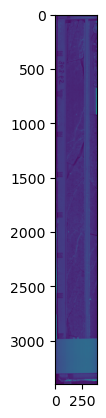

In [26]:
plt.imshow(data_array[:,:,120])

Primary data array is shaped: (3400, 384, 288)
Dark  ref array is shaped:    (100, 384, 288)
White ref array is shaped:    (100, 384, 288)


ImageView object:
  Display bands       :  (100, 100, 100)
  Interpolation       :  <default>
  RGB data limits     :
    R: [0.018515588715672493, 4.863864421844482]
    G: [0.018515588715672493, 4.863864421844482]
    B: [0.018515588715672493, 4.863864421844482]

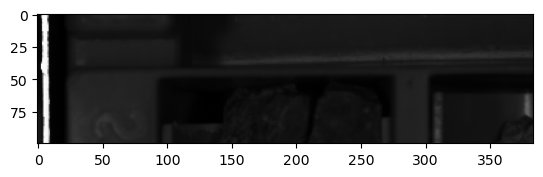

In [7]:
# Using correction formula, the captured data is subtracted by dark reference and divided with white reference subtracted dark reference. To show our currently corrected image, use imshow from spectral library.

# We have some data shape issues, let's have a look
print("Primary data array is shaped: " + str(data_array.shape))
print("Dark  ref array is shaped:    " + str(dark_array.shape))
print("White ref array is shaped:    " + str(white_array.shape))

# So it lines up along the last two dims, and we have way more in the 1st dimension of the primary data
# Can we just use that subset?

corrected_array = np.divide(
    np.subtract(data_array[0:100,:,:], dark_array),
    np.subtract(white_array, dark_array))

imshow(corrected_array, (100, 100, 100))

## What does the 3rd dimension of a single pixel look like?

The above image comes in at 3400 pixels by 384 pixels by 288 channels. Presumably that's a generally core shaped
long image across a variety of hyperspectral channels. If we look at those channels across a single pixel we'll get this

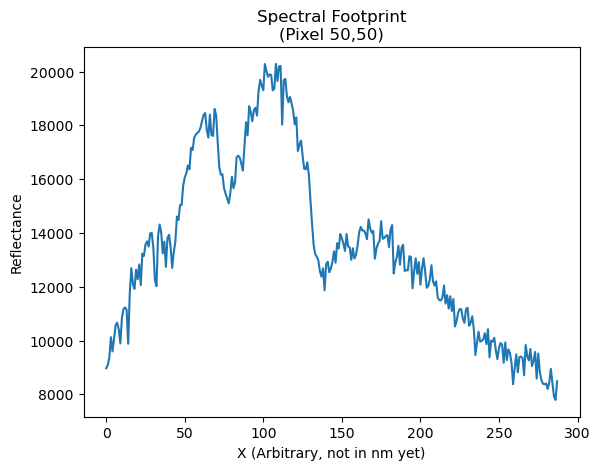

In [12]:
y_pix = 50
x_pix = 50

pix_corrected = data_array[
    y_pix:y_pix+1,
    x_pix:x_pix+1,
    :]

leaf_pixel_squeezed = np.squeeze(pix_corrected)

plt.plot(leaf_pixel_squeezed)
plt.title('Spectral Footprint\n(Pixel {},{})'.format(
    x_pix, y_pix))
plt.xlabel('X (Arbitrary, not in nm yet)')
plt.ylabel('Reflectance')
plt.show()

Other work that we've identified wants to take a white/black corrected version of the data
by 

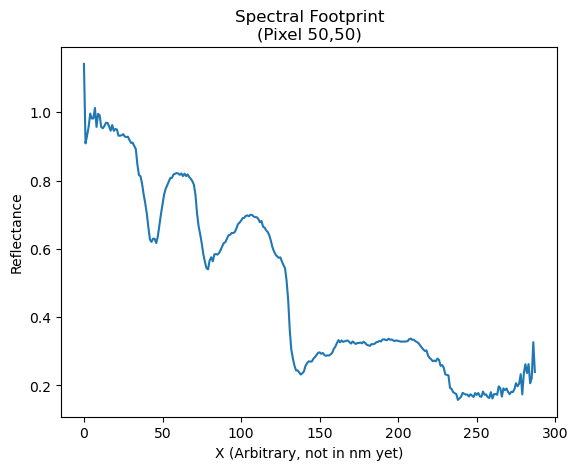

In [8]:
y_pix = 50
x_pix = 50

pix_corrected = corrected_nparr[
    y_pix:y_pix+1,
    x_pix:x_pix+1,
    :]

leaf_pixel_squeezed = np.squeeze(pix_corrected)

plt.plot(leaf_pixel_squeezed)
plt.title('Spectral Footprint\n(Pixel {},{})'.format(
    x_pix, y_pix))
plt.xlabel('X (Arbitrary, not in nm yet)')
plt.ylabel('Reflectance')
plt.show()


## Work using Python based Spectral package

note that we're using an internal function here and :

```
Changed in version 0.16.0: By default, imshow function applies a linear histogram stretch of the RGB display data. The the color stretch can be controlled by the stretch, bounds, and stretch_all keyword to the imshow function (see get_rgb for the meaning of these keywords). To adjust the color stretch of a displayed image, the set_rgb_options method of the ImageView object can be called.
```

and 

```
If `bands` has 3 values, the bands specified are extracted from
`data` to be plotted as the red, green, and blue colors,
respectively. If it contains a single value, then a single band
will be extracted from the image.```


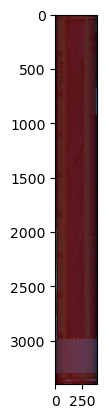

In [48]:
from spectral import *
# img = open_image('92AV3C.lan')
view = imshow(data_ref, (1, 50, 130))
# imshow(data_ref)
# imshow?


In [51]:
# Run on Python 2.7 and 3.x

from __future__ import print_function

%matplotlib inline

import os
import pysptools.spectro as spectro


class SpecLib(object):

    def __init__(self, lib_name):
        rd = spectro.EnviReader(lib_name)
        self.lib = spectro.USGS06SpecLib(rd)

    def get(self, substance, sample):
        for spectrum, sample_id, descrip, idx in self.lib.get_substance(substance, sample):
            return spectrum

    def get_wvl(self):
        return self.lib.get_wvl()


def display_convex_hull(lib, substance, sample):
    spectrum = lib.get(substance, sample)
    wvl = lib.get_wvl()

    schq = spectro.SpectrumConvexHullQuotient(spectrum, wvl)
    display_name = '{0}_{1}'.format(substance, sample)
    schq.display(display_name)


def extract_and_display_features(lib, baseline, substance, sample):
    """
    Process the s06av95a_envi file and extract the <substance> and/or <sample>
    features according to the <baseline> value.
    """
    spectrum = lib.get(substance, sample)
    wvl = lib.get_wvl()
    fea = spectro.FeaturesConvexHullQuotient(spectrum, wvl, baseline=baseline)
    display_name = '{0}_{1}'.format(substance, sample)
    fea.display(display_name, feature='all')


# substances = [('Biotite', 'WS660'),
#             ('Chalcedony', 'CU91-6A'),
#             ('Kaolinite', 'CM7'),
#             ('Gibbsite', 'HS423.3B')]

# data_path = os.environ['PYSPTOOLS_USGS']

# spec_lib = 's06av95a_envi.hdr'
# lib_path = os.path.join(data_path, spec_lib)

# lib = SpecLib(lib_path)
# base = 0.93
# for substance,sample in substances:
#     print('Convex hull and features for {0} {1}'.format(substance,sample))
#     display_convex_hull(lib, substance, sample)
#     extract_and_display_features(lib, base, substance, sample)

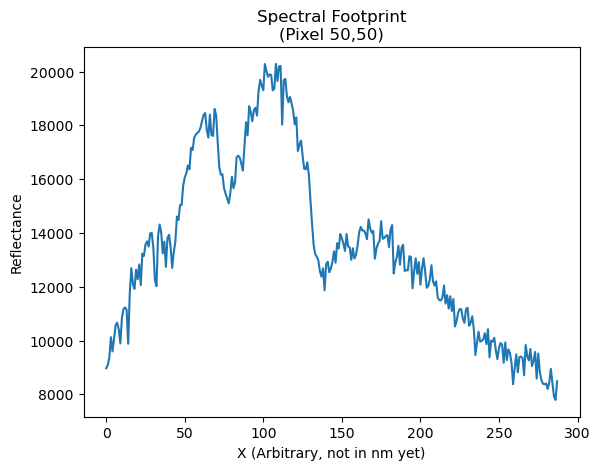

<Figure size 640x480 with 0 Axes>

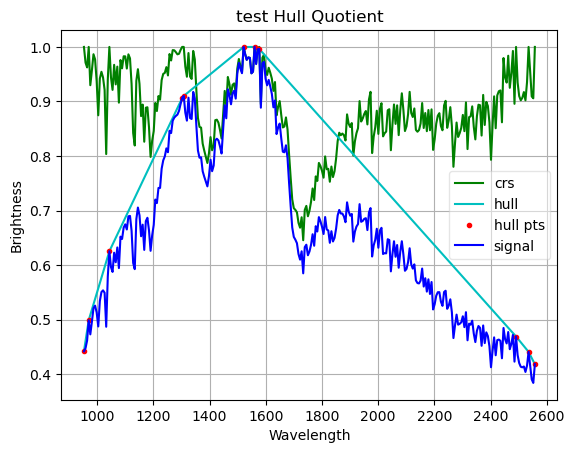

In [168]:
y_pix = 50
x_pix = 50

pix_corrected = data_array[
    y_pix:y_pix+1,
    x_pix:x_pix+1,
    :]

leaf_pixel_squeezed = np.squeeze(pix_corrected)
plt.figure()
plt.plot(leaf_pixel_squeezed)
plt.title('Spectral Footprint\n(Pixel {},{})'.format(
    x_pix, y_pix))
plt.xlabel('X (Arbitrary, not in nm yet)')
plt.ylabel('Reflectance')

pixel_normalized = np.squeeze(pix_corrected) / np.squeeze(pix_corrected).max()


plt.figure()

chr = spectro.SpectrumConvexHullQuotient(pixel_normalized.tolist(), data_ref.bands.centers)
# plt.plot(chr[0])

plt.show()
chr.display('test')

### From Jira:

Product ID
Applicable Mineral Groups
Minima From
Minima To
 
 
 
 
sp-0900
iron oxides (goethite, hematite)
820
980
sp-1000
pyroxene
880
1150
sp-1400
micas, clays
1370
1420
sp-1460
jarosite
1450
1490
sp-1480
alunite
1465
1500
sp-1550
epidote
1535
1565
sp-1760
sulphates
1710
1785
sp-1900
all OH, zeolites
1890
1940
sp-1940
gypsum
1935
1960
sp-2160
pyrophyllite
2145
2185
sp-2200
Al-OH
2185
2230
sp-2250
chlorite, biotite
2230
2265
sp-2280
Al-fe smectites
2220
2300
sp-2300
Fe-Mg smectites
2270
2330
sp-2340
carbonate
2300
2375
sp-2350
chlorite, biotite
2325
2370
sp-2360
tourmaline
2345
2390
sp-2380
amphiboles, biotite
2375
2415

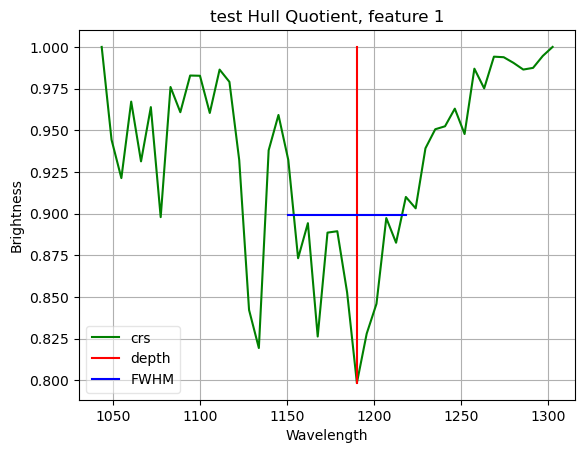

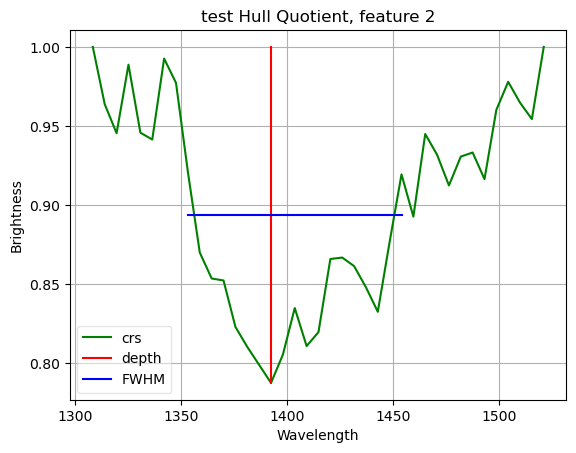

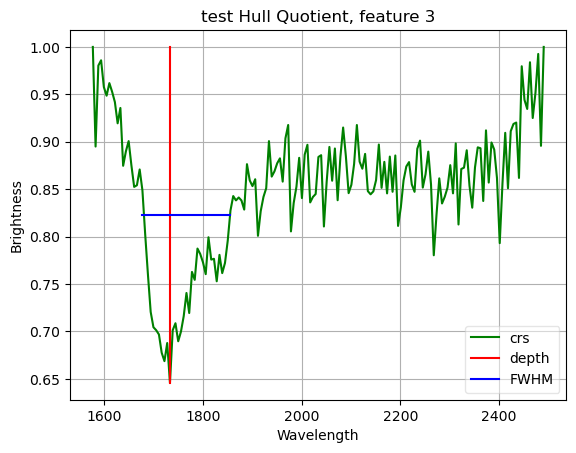

<Figure size 640x480 with 0 Axes>

In [183]:
fea = spectro.FeaturesConvexHullQuotient(pixel_normalized.tolist(), data_ref.bands.centers, baseline = 0.8)
# display_name = '{0}_{1}'.format(substance, sample)
fea.display('test')

## Maybe now from the data that Cari sent

   Wavelength (Micrometers)  Reflectence (percent)
0                     0.406                  47.75
1                     0.407                  48.04
2                     0.408                  48.27
3                     0.409                  48.56
4                     0.410                  48.85


<Axes: xlabel='Wavelength (Micrometers)'>

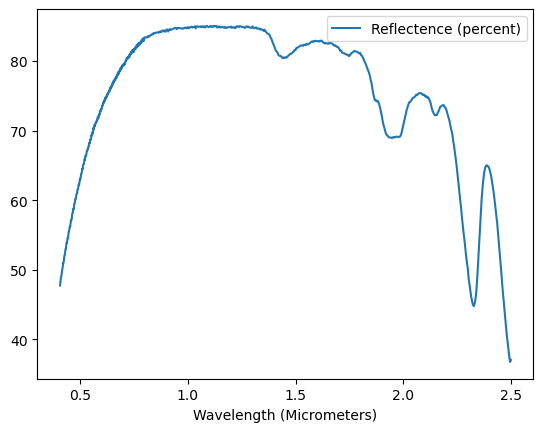

In [194]:
import pandas as pd

cdata_dir = '/Users/mmelnick/Work/Veracio/data/Subset Ecostress Library - VNIR-SWIR/'
cdata_file = "mineral.carbonate.none.coarse.vswir.c-3a.jpl.beckman.spectrum" + '.txt'

# Read the text file into a DataFrame, skipping the first 27 rows
df = pd.read_csv(cdata_dir + cdata_file, 
                 skiprows=27, delimiter='\t', 
                 header=None, 
                 names=['Wavelength (Micrometers)', 'Reflectence (percent)'])
print(df.head())
df.describe()
df = df.set_index('Wavelength (Micrometers)')
df.plot()

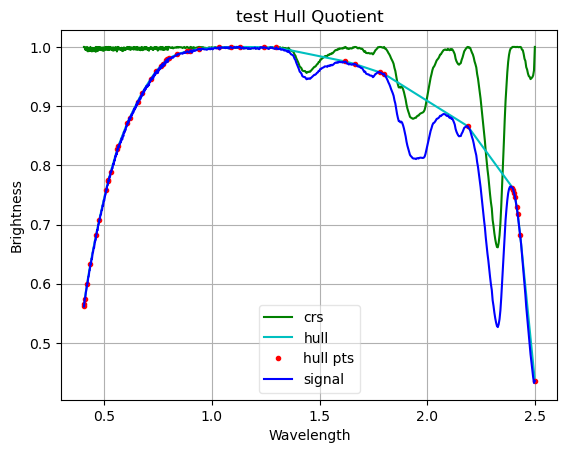

In [195]:
curr_data = df['Reflectence (percent)'].values
curr_data_normalized = curr_data / curr_data.max()
# plt.figure()
# plt.plot()
# plt.title('Spectral Footprint\n(from file: {})'.format(
#     cdata_file))
# plt.xlabel('Wavelength (micrometers)')
# plt.ylabel('Reflectance ( percent)')

# data_normalized = df['Reflectence (percent)'].values() / df['Reflectence (percent)'].values().max()


# plt.figure()

chr = spectro.SpectrumConvexHullQuotient(curr_data_normalized.tolist(),
                                         df.index.tolist())
# plt.plot(chr[0])

plt.show()
chr.display('test')

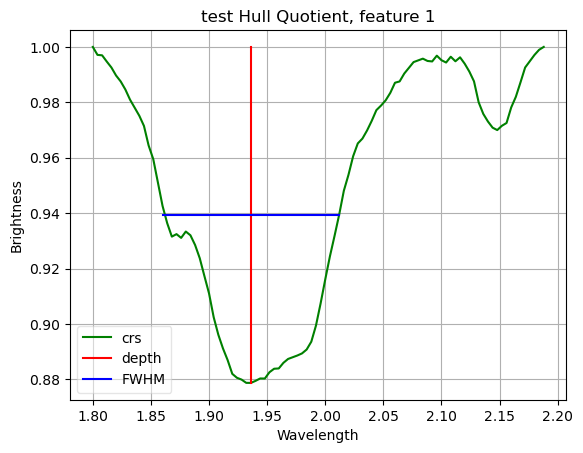

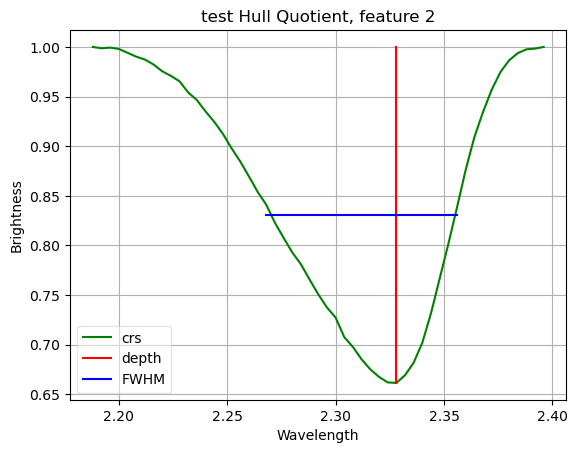

<Figure size 640x480 with 0 Axes>

In [202]:
fea = spectro.FeaturesConvexHullQuotient(curr_data_normalized.tolist(),
                                         df.index.tolist(),
                                         baseline = 0.9)
# display_name = '{0}_{1}'.format(substance, sample)
fea.display('test')
# spectro.FeaturesConvexHullQuotient?


In [204]:
import numpy as np
import scipy.signal as signal
import scipy.interpolate as interpolate

def boxcar_convolve(spectrum, width):
    boxcar = np.ones(width) / width
    return np.convolve(spectrum, boxcar, mode='same')

def find_lower_hull_nodes(spectrum):
    minima_indices = signal.argrelextrema(spectrum, np.less)
    return minima_indices

def construct_hull_curve(nodes, spectrum_length):
    if len(nodes[0]) == 0:
        return np.zeros(spectrum_length)
    x = np.arange(spectrum_length)
    hull_curve = interpolate.interp1d(x[nodes], nodes[0], kind='linear', fill_value='extrapolate', bounds_error=False)
    return hull_curve(x)

def find_upper_hull_nodes(spectrum):
    maxima_indices = signal.argrelextrema(spectrum, np.greater)
    return maxima_indices

def remove_zero_crossings(spectrum, hull_curve):
    zero_crossings = np.where(np.diff(np.sign(spectrum - hull_curve)))[0]
    return zero_crossings

def construct_geometric_hull(spectrum):
    spectrum_length = len(spectrum)
    filter_lengths = [int(0.02 * spectrum_length), int(0.1 * spectrum_length)]

    smoothed_spectra = []
    for filter_length in filter_lengths:
        smoothed_spectrum = boxcar_convolve(boxcar_convolve(spectrum, filter_length), filter_length)
        smoothed_spectra.append(smoothed_spectrum)

    difference_of_gaussians = smoothed_spectra[1] - smoothed_spectra[0]
    std_deviation = np.std(difference_of_gaussians)
    optimal_filter_length = filter_lengths[np.argmax(std_deviation)]

    smoothed_spectrum = boxcar_convolve(boxcar_convolve(spectrum, optimal_filter_length), optimal_filter_length)
    divided_spectrum = spectrum / smoothed_spectrum

    lower_hull_nodes = find_lower_hull_nodes(divided_spectrum)
    lower_hull = construct_hull_curve(lower_hull_nodes, spectrum_length)
    preliminary_minima_zeroed = spectrum - lower_hull

    upper_hull_nodes = find_upper_hull_nodes(preliminary_minima_zeroed)
    preliminary_upper_hull = construct_hull_curve(upper_hull_nodes, spectrum_length)

    iteration_count = 0
    while True:
        subtracted_spectrum = spectrum - preliminary_upper_hull
        zero_crossings = remove_zero_crossings(subtracted_spectrum, preliminary_upper_hull)
        if len(zero_crossings) == 0 or iteration_count > 10:
            break

        upper_hull_nodes = np.union1d(upper_hull_nodes, zero_crossings)
        preliminary_upper_hull = construct_hull_curve(upper_hull_nodes, spectrum_length)
        iteration_count += 1

    final_geometric_hull = preliminary_upper_hull
    return final_geometric_hull

# Example usage
spectrum = curr_data_normalized
geometric_hull = construct_geometric_hull(spectrum)


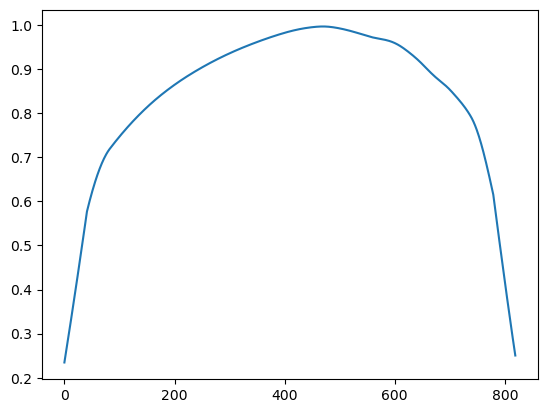

In [211]:
spectrum_length = len(spectrum)
filter_lengths = [int(0.02 * spectrum_length), int(0.1 * spectrum_length)]

smoothed_spectra = []
for filter_length in filter_lengths:
    smoothed_spectrum = boxcar_convolve(boxcar_convolve(spectrum, filter_length), filter_length)
    smoothed_spectra.append(smoothed_spectrum)
    
plt.plot(smoothed_spectrum)